In [4]:
# one way of opening a csv file
import os 
fname = "jena_climate_2009_2016.csv"
f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(header))
print(len(lines))
print([lines[0]])
print(type(lines[0])) # this shows that our csv data is imported as one long string

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420551
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']
<class 'str'>


In [8]:
import numpy as np
float_data = np.zeros((len(lines),len(header) - 1))
print(float_data.shape)

# enumerate - provides the index of each thing your for looping as well
# this does a string to float transform, dropping the data/time column to begin with (because the data/time is not a float, and we know that our dataset is order)
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

print(float_data[0])
print()

(420551, 14)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


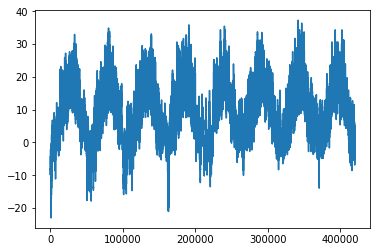

In [13]:
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

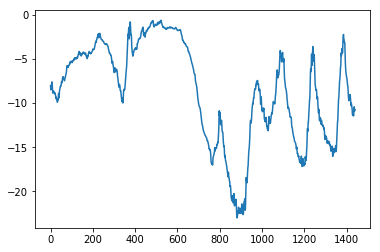

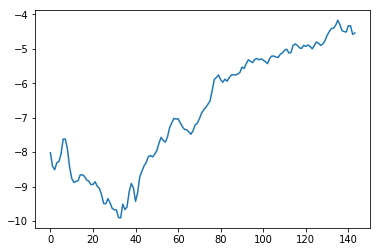

In [16]:
# this is a 10 day view of the data (as data is in 10min intervals)
plt.plot(range(1440),temp[:1440])
plt.show()
plt.close()

# this is a 1 day view of the data
plt.plot(range(144),temp[:144])
plt.show()
plt.close()

In [18]:
# let's begin by normalising the data. Setting axis=0 means we find the average over the feature (column), rather than sample (row)
mean = float_data[:200000].mean(axis=0)
print(mean.shape) # this is 14, so we know we've calculated the right number of means, one for each column
float_data -= mean # this line zero centres our data
std = float_data[:200000].std(axis=0)
float_data /= std # this divided each by the std

(14,)


In [33]:
lookback = 1440 # 10 days in the past
step = 6 # one sample per hour
delay = 144 # target 24h in the future
min_index = 0
max_index = 200000
batch_size = 128

# this generator is quite flexible
# if we don't shuffle, it cycles through the inputs going through from beginning to end of the data and then starts again

# for training, the generator shuffles the data. And then you can change how far you look into the past / future also
# so you can say how much data you want to see into the past, and how much you want to see into the future

def generator(
    data,
    lookback, delay,
    min_index, max_index,
    shuffle=False, 
    batch_size=batch_size,
    step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback # TODO redundant?
    while True:

        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

g = generator(float_data,lookback,delay,min_index,max_index)
next(g) # this calls the next element of the generator

(array([[[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
          -0.78067973, -0.27613603],
         [ 0.89778911, -1.88617347, -1.93631689, ..., -1.28265064,
          -1.26122763, -0.11218879],
         [ 0.91311851, -2.02511729, -2.07481421, ..., -1.29566585,
          -1.31700551, -0.20686255],
         ...,
         [ 0.90722258, -2.19117209, -2.23900055, ...,  0.41583332,
           0.34774971, -1.86780973],
         [ 0.96146509, -2.23861632, -2.29037859, ...,  0.38329531,
           0.07744152, -1.77059594],
         [ 1.00627412, -2.37643051, -2.42999282, ..., -0.02017597,
          -0.08131091, -2.00254665]],
 
        [[ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
          -0.88794488, -0.46317443],
         [ 0.89778911, -1.88617347, -1.93631689, ..., -1.27614304,
          -1.31700551, -0.66522209],
         [ 0.92608954, -2.02285804, -2.0736973 , ..., -1.16551382,
          -1.26122763,  0.09909533],
         ...,
         [ 0.92255199, -2.2013387

In [34]:
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [42]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Flatten(
    input_shape=(lookback//step,float_data.shape[-1])
))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dense(1))

model.summary()

model.compile(
    optimizer = optimizers.RMSprop(lr=0.001),
    loss="mse",
    metrics=["mae"]
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = 500,
    epochs = 20,
    validation_data = val_gen,
    validation_steps = val_steps//100
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                53792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 35s 71ms/step - loss: 1.2289 - mean_absolute_error: 0.7134 - val_loss: 0.2923 - val_mean_absolute_error: 0.4375
Epoch 2/20
500/500 [==============================] - 36s 71ms/step - loss: 0.2757 - mean_absolute_error: 0.3961 - val_loss: 0.1381 - val_mean_absolute_error: 0.2935
Epoch 3/20
500/500 [==============================] - 51s 102ms/step -

In [46]:
model = models.Sequential()
model.add(layers.GRU(
    32,
    input_shape = (None,float_data.shape[-1])
))
model.add(layers.Dense(1))


model.summary()

model.compile(
    optimizer = optimizers.RMSprop(),
    loss="mse",
    metrics=["mae"]
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = 500,
    epochs = 20,
    validation_data = val_gen,
    validation_steps = val_steps // 100
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 10/500 [..............................] - ETA: 6:58 - loss: 0.3014 - mean_absolute_error: 0.4179

KeyboardInterrupt: 